In [236]:
#Importing the necessary Libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc


import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

In [2]:
#Reading the dataset

df = pd.read_csv('fraud_data.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.shape

(6362620, 11)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 485.4+ MB


In [5]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [7]:
8213/6354407

0.0012924888191769902

The simulated dataset is heavily imbalanced: the fraudulent transactions make up less than 0.13% of the entire dataset. 

In [15]:
df['isFlaggedFraud'].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

A very large majority of the transactions are not flagged as fraudulent: only 16 of the total 6354407 are flagged as fraud. It is easy to see that this variable would not contribute no meaningful information and so we can remove it from the dataset. 

In [16]:
df.drop(['isFlaggedFraud'],axis=1,inplace=True)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


Analyzing Fraudulent transactions

In [19]:
temp = df[df['isFraud'] == 1]
temp.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1


In [20]:
temp.shape

(8213, 10)

In [23]:
temp[['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]

,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
2,181.00,0.0,0.00,0.00
3,181.00,0.0,21182.00,0.00
251,2806.00,0.0,0.00,0.00
252,2806.00,0.0,26202.00,0.00
680,20128.00,0.0,0.00,0.00
...,...,...,...,...
6362615,339682.13,0.0,0.00,339682.13
6362616,6311409.28,0.0,0.00,0.00
6362617,6311409.28,0.0,68488.84,6379898.11
6362618,850002.52,0.0,0.00,0.00


In [28]:
temp['newbalanceOrig'].value_counts()

0.00           8053
17316255.05       3
10399045.08       3
19585040.37       3
4953893.08        2
               ... 
34892193.09       1
1975271.77        1
11975271.77       1
1653144.10        1
29585040.37       1
Name: newbalanceOrig, Length: 145, dtype: int64

In [32]:
temp['newbalanceDest'].value_counts()

0.00           4091
10000000.00      53
1064995.85        2
127905.82         2
1165187.89        2
               ... 
3098931.52        1
143526.32         1
1532241.85        1
495991.64         1
7360101.63        1
Name: newbalanceDest, Length: 4067, dtype: int64

In [35]:
temp['oldbalanceDest'].value_counts()

0.00          5351
386985.85        1
716857.20        1
8682013.45       1
6493.14          1
              ... 
388830.36        1
261802.02        1
346223.18        1
85009.83         1
6510099.11       1
Name: oldbalanceDest, Length: 2863, dtype: int64

In [37]:
temp['oldbalanceOrg'].value_counts()

10000000.00    142
0.00            41
1165187.89       4
429257.45        4
181.00           2
              ... 
19110884.44      1
29110884.44      1
4892193.09       1
14892193.09      1
12740879.15      1
Name: oldbalanceOrg, Length: 4094, dtype: int64

Amongst the fraudulent transactions, the most common value the 'newbalanceOrig', 'newbalanceDest', and 'oldbalanceDest' variables take is 0.0. This is the same as a majority of these variables possessing missing values. The 'oldbalanceOrig' variable takes on a much larger variety of values, and thus it can be easily understood that this variable may contribute important information to help differentiate between fraudulent and non-fraudulent transactions

Analyzing non-fraudulent transactions

In [38]:
temp = df[df['isFraud'] == 0]
temp.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0
5,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0
6,1,PAYMENT,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,0


In [39]:
temp.shape

(6354407, 10)

In [40]:
temp[['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]

,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,170136.0,160296.36,0.00,0.00
1,21249.0,19384.72,0.00,0.00
4,41554.0,29885.86,0.00,0.00
5,53860.0,46042.29,0.00,0.00
6,183195.0,176087.23,0.00,0.00
...,...,...,...,...
6362319,518802.0,510167.71,0.00,0.00
6362320,3859.0,0.00,0.00,159188.22
6362321,168046.0,0.00,24893.67,211167.51
6362322,13492.0,0.00,0.00,82096.45


In [41]:
temp['newbalanceOrig'].value_counts()

0.00          3601513
20981.68            4
31285.61            4
17979.82            4
4019.43             4
               ...   
2488448.03          1
2594227.40          1
2795361.14          1
3102907.34          1
510167.71           1
Name: newbalanceOrig, Length: 2682442, dtype: int64

In [42]:
temp['newbalanceDest'].value_counts()

0.00           2435342
971418.91           32
19169204.93         29
16532032.16         25
1254956.07          25
                ...   
199687.19            1
1011484.91           1
748082.74            1
1697578.22           1
190610.24            1
Name: newbalanceDest, Length: 3552702, dtype: int64

In [43]:
temp['oldbalanceDest'].value_counts()

0.00           2699037
10000000.00        615
20000000.00        219
30000000.00         86
40000000.00         31
                ...   
439004.90            1
542311.75            1
287276.41            1
272373.07            1
188746.00            1
Name: oldbalanceDest, Length: 3611910, dtype: int64

In [44]:
temp['oldbalanceOrg'].value_counts()


0.00         2102408
184.00           918
133.00           914
195.00           912
109.00           908
              ...   
398420.23          1
402324.00          1
73493.53           1
425466.00          1
518802.00          1
Name: oldbalanceOrg, Length: 1841867, dtype: int64

In [51]:
t1 = len(df[(df['isFraud'] == 1) & (df['oldbalanceOrg'] == 0)])/len(df[df['isFraud'] == 1])
t2 = len(df[(df['isFraud'] == 0) & (df['oldbalanceOrg'] == 0)])/len(df[df['isFraud'] == 0])

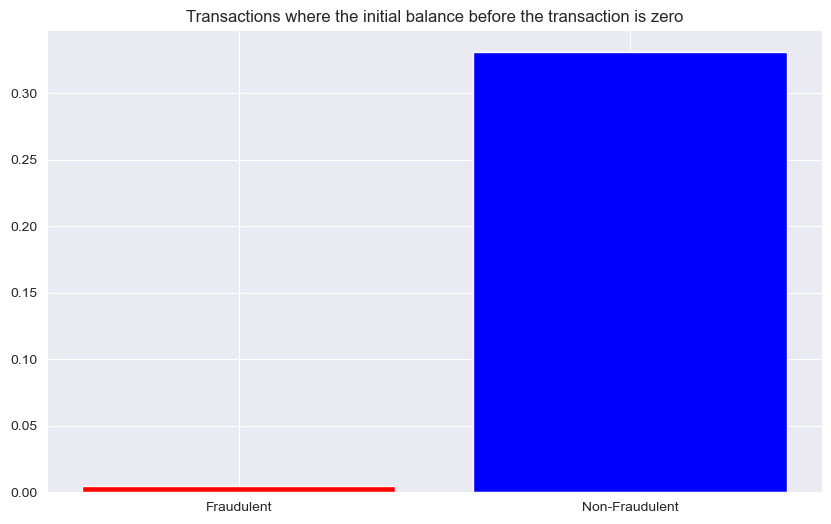

In [57]:
plt.figure(figsize=(10,6))
plt.bar(['Fraudulent','Non-Fraudulent'],[t1,t2],color=['red','blue'])
plt.title('Transactions where the initial balance before the transaction is zero')
plt.show()

Amongst the non-fraudulent transactions almost all instances of the 'newbalanceOrig', 'newbalanceDest', 'oldbalanceOrig', and 'oldbalanceDest' adopt the value zero. Keeping in mind the results obtained from analysing the fraudulent transactions, it's apt to remove the following variables from the dataset: 'newbalanceOrig', 'newbalanceDest', and 'oldbalanceDest'. 

In [58]:
df = df.drop(['newbalanceOrig','oldbalanceDest','newbalanceDest'],axis=1)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,nameDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,M1979787155,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,M2044282225,0
2,1,TRANSFER,181.00,C1305486145,181.0,C553264065,1
3,1,CASH_OUT,181.00,C840083671,181.0,C38997010,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,M1230701703,0


Analyzing the type variable

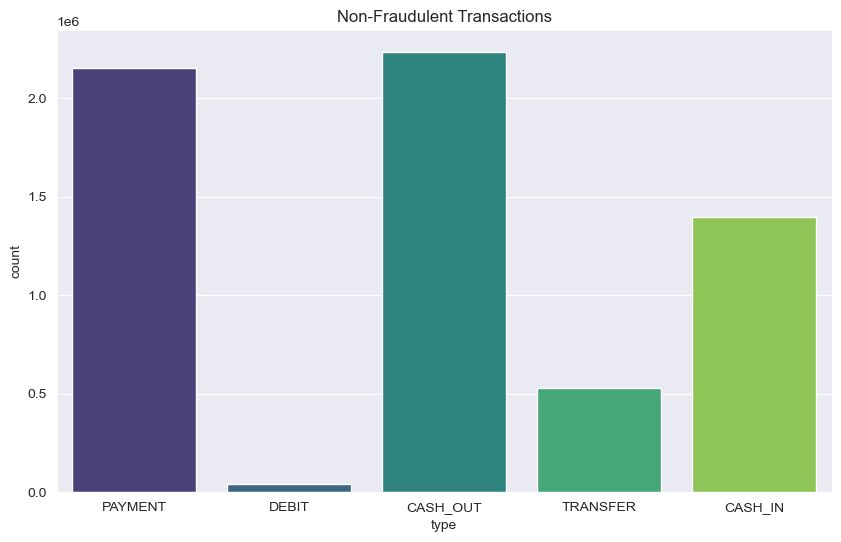

In [71]:

plt.figure(figsize=(10,6))
sns.countplot(x='type', data=df[df['isFraud'] == 0],palette='viridis')
plt.title('Non-Fraudulent Transactions')
plt.show()

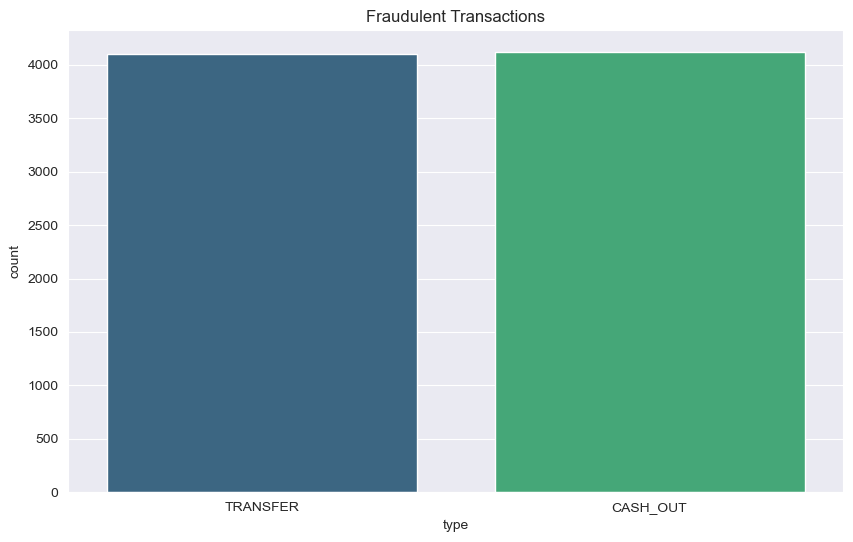

In [72]:
plt.figure(figsize=(10,6))
sns.countplot(x='type', data=df[df['isFraud'] == 1],palette='viridis')
plt.title('Fraudulent Transactions')
plt.show()

Looking at the above figures, it's easy to see that the fraudulent transactions tend to be mostly cashouts or transfers. 

Analyzing the step variable

In [84]:
df['step'].nunique()

743

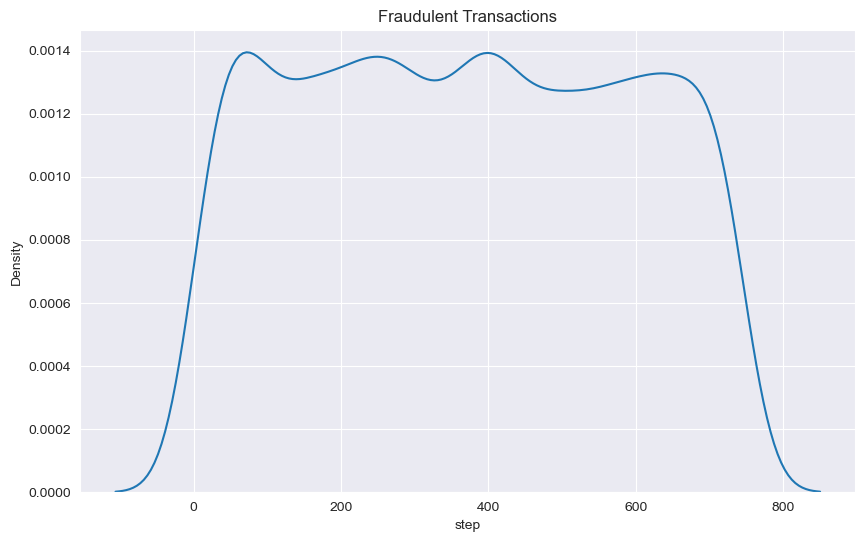

In [86]:
plt.figure(figsize=(10,6))
sns.kdeplot(x='step',data=df[df['isFraud'] == 1])
plt.title('Fraudulent Transactions')
plt.show()

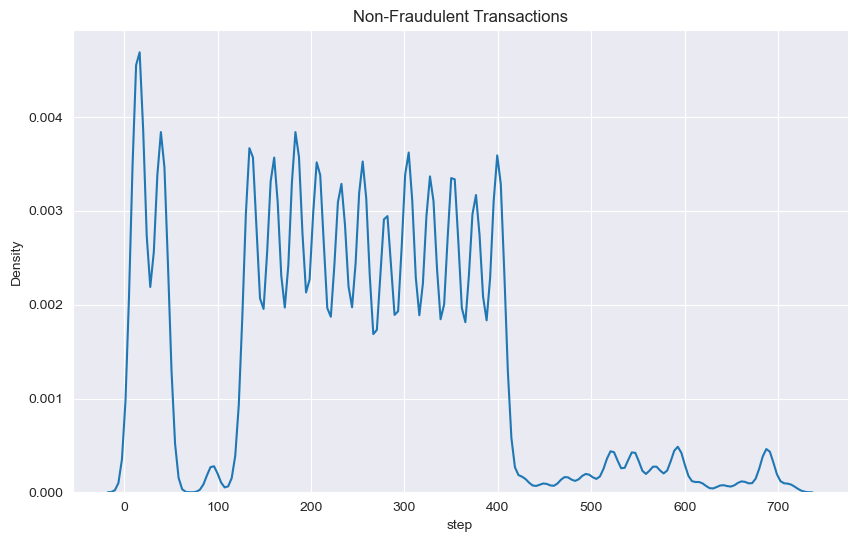

In [87]:
plt.figure(figsize=(10,6))
sns.kdeplot(x='step',data=df[df['isFraud'] == 0])
plt.title('Non-Fraudulent Transactions')
plt.show()

Analyzing the amount transacted

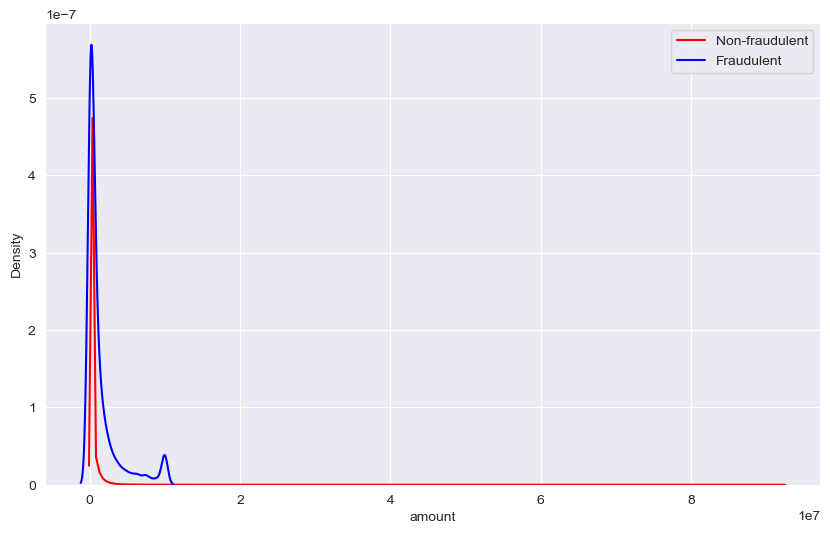

In [92]:
plt.figure(figsize=(10,6))
sns.kdeplot(x='amount',data=df[df['isFraud'] == 0],color='red')
sns.kdeplot(x='amount',data=df[df['isFraud'] == 1],color='blue')
plt.legend(['Non-fraudulent','Fraudulent'])
plt.show()

The amount transacted seems to follow almost the same distribution for fraudulent and non-fraudulent transactions. It doesn't seem to provide any useful information that may help one differentiate between the types of transactions. 

In [94]:
df.drop(['amount'],axis=1,inplace=True)

In [95]:
df.head()

,step,type,nameOrig,oldbalanceOrg,nameDest,isFraud
0,1,PAYMENT,C1231006815,170136.0,M1979787155,0
1,1,PAYMENT,C1666544295,21249.0,M2044282225,0
2,1,TRANSFER,C1305486145,181.0,C553264065,1
3,1,CASH_OUT,C840083671,181.0,C38997010,1
4,1,PAYMENT,C2048537720,41554.0,M1230701703,0


The names of the origins and destinations are made up of a letter and a number sequence immediately succeeding it. Two new variables are defined: 'nameOrigx' and 'nameDestx' that store the letters 

In [115]:
df['nameOrigx'] = df['nameOrig'].apply(lambda x: x[0])

In [116]:
df.head()

,step,type,nameOrig,oldbalanceOrg,nameDest,isFraud,nameOrigx,nameDestx
0,1,PAYMENT,C1231006815,170136.0,M1979787155,0,C,M
1,1,PAYMENT,C1666544295,21249.0,M2044282225,0,C,M
2,1,TRANSFER,C1305486145,181.0,C553264065,1,C,C
3,1,CASH_OUT,C840083671,181.0,C38997010,1,C,C
4,1,PAYMENT,C2048537720,41554.0,M1230701703,0,C,M


In [117]:
df['nameDestx'] = df['nameDest'].apply(lambda x: x[0])

In [118]:
df.head()

,step,type,nameOrig,oldbalanceOrg,nameDest,isFraud,nameOrigx,nameDestx
0,1,PAYMENT,C1231006815,170136.0,M1979787155,0,C,M
1,1,PAYMENT,C1666544295,21249.0,M2044282225,0,C,M
2,1,TRANSFER,C1305486145,181.0,C553264065,1,C,C
3,1,CASH_OUT,C840083671,181.0,C38997010,1,C,C
4,1,PAYMENT,C2048537720,41554.0,M1230701703,0,C,M


In [120]:
df['nameOrigx'].value_counts()

C    6362620
Name: nameOrigx, dtype: int64

In [119]:
df['nameDestx'].value_counts()

C    4211125
M    2151495
Name: nameDestx, dtype: int64

'nameOrigx' has only one unique value, and so the variable is dropped from the dataset

In [121]:
df.drop(['nameOrigx'],axis=1,inplace=True)

In [122]:
df.head()

,step,type,nameOrig,oldbalanceOrg,nameDest,isFraud,nameDestx
0,1,PAYMENT,C1231006815,170136.0,M1979787155,0,M
1,1,PAYMENT,C1666544295,21249.0,M2044282225,0,M
2,1,TRANSFER,C1305486145,181.0,C553264065,1,C
3,1,CASH_OUT,C840083671,181.0,C38997010,1,C
4,1,PAYMENT,C2048537720,41554.0,M1230701703,0,M


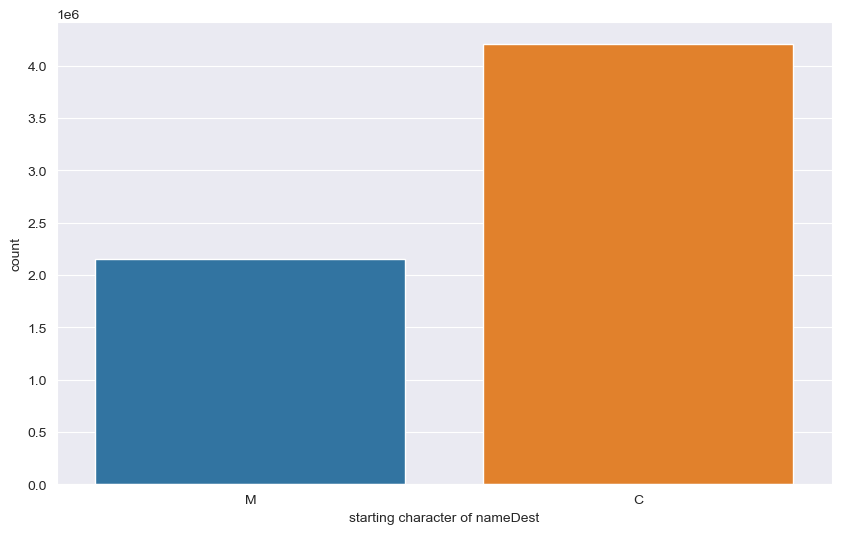

In [124]:
plt.figure(figsize=(10,6))
sns.countplot(x='nameDestx',data=df[df['isFraud'] == 0])
plt.xlabel('starting character of nameDest')
plt.show()

There are only two types of characters in 'nameDestx': 'M' and 'C'. 'M' is encoded as 1 and 'C' is encoded as 0. 

In [125]:
df['nameDestx'] = df['nameDestx'].replace({'M':1,'C':0})
df.head()

,step,type,nameOrig,oldbalanceOrg,nameDest,isFraud,nameDestx
0,1,PAYMENT,C1231006815,170136.0,M1979787155,0,1
1,1,PAYMENT,C1666544295,21249.0,M2044282225,0,1
2,1,TRANSFER,C1305486145,181.0,C553264065,1,0
3,1,CASH_OUT,C840083671,181.0,C38997010,1,0
4,1,PAYMENT,C2048537720,41554.0,M1230701703,0,1


Two more variables are defined: 'nameOrigNum' and 'nameDestNum' that capture the sequence of numbers in the 'nameOrig' and 'nameDest' variable

In [140]:
def extractNumber(ele):
    return int(ele[1:])

df['nameOrigNum'] = df['nameOrig'].apply(extractNumber)
df['nameDestNum'] = df['nameDest'].apply(extractNumber)

In [141]:
df.head()

,step,type,nameOrig,oldbalanceOrg,nameDest,isFraud,nameDestx,nameOrigNum,nameDestNum
0,1,PAYMENT,C1231006815,170136.0,M1979787155,0,1,1231006815,1979787155
1,1,PAYMENT,C1666544295,21249.0,M2044282225,0,1,1666544295,2044282225
2,1,TRANSFER,C1305486145,181.0,C553264065,1,0,1305486145,553264065
3,1,CASH_OUT,C840083671,181.0,C38997010,1,0,840083671,38997010
4,1,PAYMENT,C2048537720,41554.0,M1230701703,0,1,2048537720,1230701703


Analyzing nameOrigNum of the fraudulent transactions

In [156]:
temp = df[df['isFraud'] == 1]
temp.head()

,step,type,nameOrig,oldbalanceOrg,nameDest,isFraud,nameDestx,nameOrigNum,nameDestNum
2,1,TRANSFER,C1305486145,181.0,C553264065,1,0,1305486145,553264065
3,1,CASH_OUT,C840083671,181.0,C38997010,1,0,840083671,38997010
251,1,TRANSFER,C1420196421,2806.0,C972765878,1,0,1420196421,972765878
252,1,CASH_OUT,C2101527076,2806.0,C1007251739,1,0,2101527076,1007251739
680,1,TRANSFER,C137533655,20128.0,C1848415041,1,0,137533655,1848415041


In [183]:
series1 = temp['nameOrigNum']
series1.head()

2      1305486145
3       840083671
251    1420196421
252    2101527076
680     137533655
Name: nameOrigNum, dtype: int64

In [184]:
series1 = series1.reset_index(drop=True)
series1.head()

0    1305486145
1     840083671
2    1420196421
3    2101527076
4     137533655
Name: nameOrigNum, dtype: int64

In [186]:
temp = df[df['isFraud'] == 0]
temp.head()

,step,type,nameOrig,oldbalanceOrg,nameDest,isFraud,nameDestx,nameOrigNum,nameDestNum
0,1,PAYMENT,C1231006815,170136.0,M1979787155,0,1,1231006815,1979787155
1,1,PAYMENT,C1666544295,21249.0,M2044282225,0,1,1666544295,2044282225
4,1,PAYMENT,C2048537720,41554.0,M1230701703,0,1,2048537720,1230701703
5,1,PAYMENT,C90045638,53860.0,M573487274,0,1,90045638,573487274
6,1,PAYMENT,C154988899,183195.0,M408069119,0,1,154988899,408069119


In [187]:
series2 = temp['nameOrigNum'].reset_index(drop=True)
series2.head()

0    1231006815
1    1666544295
2    2048537720
3      90045638
4     154988899
Name: nameOrigNum, dtype: int64

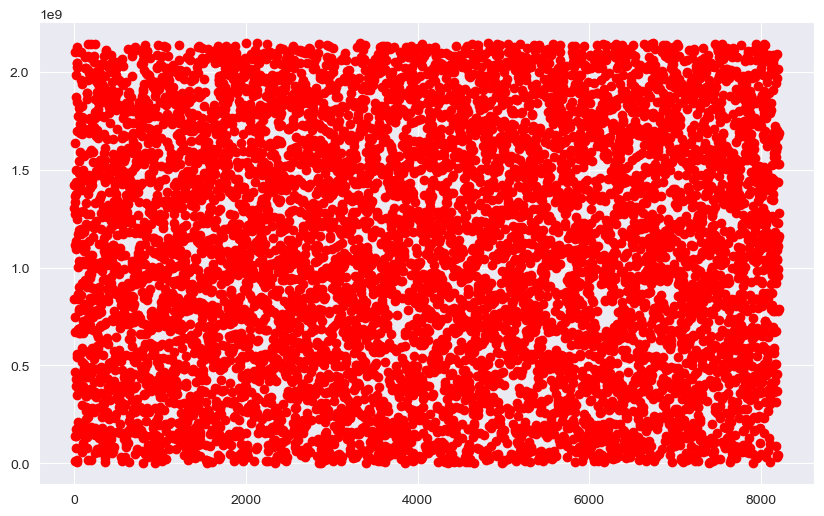

In [189]:
plt.figure(figsize=(10,6))
plt.scatter(series1.index,series1.values,marker='o',color='red')
plt.show()

The 'nameOrig' and 'nameDest' variables are dropped

In [199]:
df.drop(['nameOrig','nameDest'],axis=1,inplace=True)
df.head()

,step,type,oldbalanceOrg,isFraud,nameDestx,nameOrigNum,nameDestNum
0,1,PAYMENT,170136.0,0,1,1231006815,1979787155
1,1,PAYMENT,21249.0,0,1,1666544295,2044282225
2,1,TRANSFER,181.0,1,0,1305486145,553264065
3,1,CASH_OUT,181.0,1,0,840083671,38997010
4,1,PAYMENT,41554.0,0,1,2048537720,1230701703


Creating a training and testing dataset

In [203]:
fraud = df[df['isFraud'] == 1]
non_fraud = df[df['isFraud'] == 0]

As mentioned earlier, the provided dataset is heavily imbalanced. Instead we make a new dataset where the ratio of the non-fraudulent transactions to the frauduluent ones are 3:1.

In [213]:
all_indices = list(range(non_fraud.shape[0]))
sample_indices = random.sample(all_indices,3*fraud.shape[0])

In [218]:
df_total = pd.concat([non_fraud.iloc[sample_indices],fraud],axis=0)

In [221]:
df_total = df_total.sample(frac=1,random_state=42)

In [222]:
df_total.head()

,step,type,oldbalanceOrg,isFraud,nameDestx,nameOrigNum,nameDestNum
3683647,276,CASH_OUT,82355.00,0,0,1947360870,483714572
4938224,350,TRANSFER,0.00,0,0,265773322,1806598697
15925,8,PAYMENT,0.00,0,1,1567682689,654290745
4384507,312,CASH_OUT,6580427.81,1,0,511307813,377087678
4750255,333,CASH_OUT,22644.00,0,0,1515728794,149677412


In [223]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32852 entries, 3683647 to 123818
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   step           32852 non-null  int64  
 1   type           32852 non-null  object 
 2   oldbalanceOrg  32852 non-null  float64
 3   isFraud        32852 non-null  int64  
 4   nameDestx      32852 non-null  int64  
 5   nameOrigNum    32852 non-null  int64  
 6   nameDestNum    32852 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 2.0+ MB


The 'type' variable is one-hot encoded

In [224]:
df_total = pd.get_dummies(df_total,columns=['type'])

In [225]:
df_total.head()

,step,oldbalanceOrg,isFraud,nameDestx,nameOrigNum,nameDestNum,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
3683647,276,82355.00,0,0,1947360870,483714572,0,1,0,0,0
4938224,350,0.00,0,0,265773322,1806598697,0,0,0,0,1
15925,8,0.00,0,1,1567682689,654290745,0,0,0,1,0
4384507,312,6580427.81,1,0,511307813,377087678,0,1,0,0,0
4750255,333,22644.00,0,0,1515728794,149677412,0,1,0,0,0


In [226]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32852 entries, 3683647 to 123818
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   step           32852 non-null  int64  
 1   oldbalanceOrg  32852 non-null  float64
 2   isFraud        32852 non-null  int64  
 3   nameDestx      32852 non-null  int64  
 4   nameOrigNum    32852 non-null  int64  
 5   nameDestNum    32852 non-null  int64  
 6   type_CASH_IN   32852 non-null  uint8  
 7   type_CASH_OUT  32852 non-null  uint8  
 8   type_DEBIT     32852 non-null  uint8  
 9   type_PAYMENT   32852 non-null  uint8  
 10  type_TRANSFER  32852 non-null  uint8  
dtypes: float64(1), int64(5), uint8(5)
memory usage: 1.9 MB


In [227]:
X = df_total.drop(['isFraud'],axis=1)
y = df_total['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,shuffle=True)

In [231]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

The model used for the classification task is the xgboost classifier. A gridsearch is performed to find the optimal set of hyperparameters

In [238]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
}

xgb = XGBClassifier(objective='binary:logistic', eval_metric='error')
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy',verbose=1)
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='error', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monoto...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 2, 3],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='accuracy', verbose=1)

In [239]:
grid_search.best_params_

{'colsample_bytree': 0.9,
 'gamma': 0,
 'learning_rate': 0.2,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 200,
 'subsample': 1.0}

In [240]:
model = grid_search.best_estimator_

y_pred = model.predict(X_test)

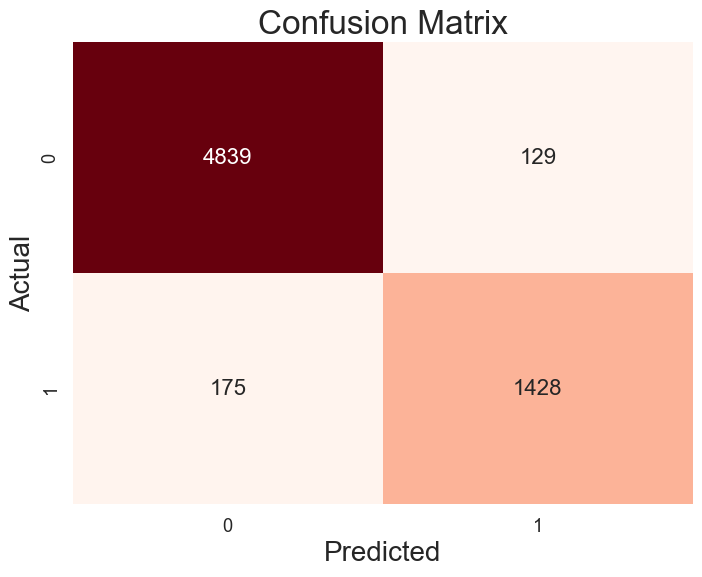

In [241]:
from sklearn.metrics import confusion_matrix

conf_matrix= confusion_matrix(y_test,y_pred)


plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
heatmap = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", annot_kws={"size": 16}, cbar=False)
plt.xlabel("Predicted",size=20)
plt.ylabel("Actual",size=20)
plt.title("Confusion Matrix",size=24)

plt.show()

In [242]:
acc = accuracy_score(y_pred,y_test)
f1 = f1_score(y_pred,y_test)


print(f'Accuracy: {acc}')
print(f'F1 Score: {f1}')


Accuracy: 0.9537361132247756
F1 Score: 0.9037974683544304


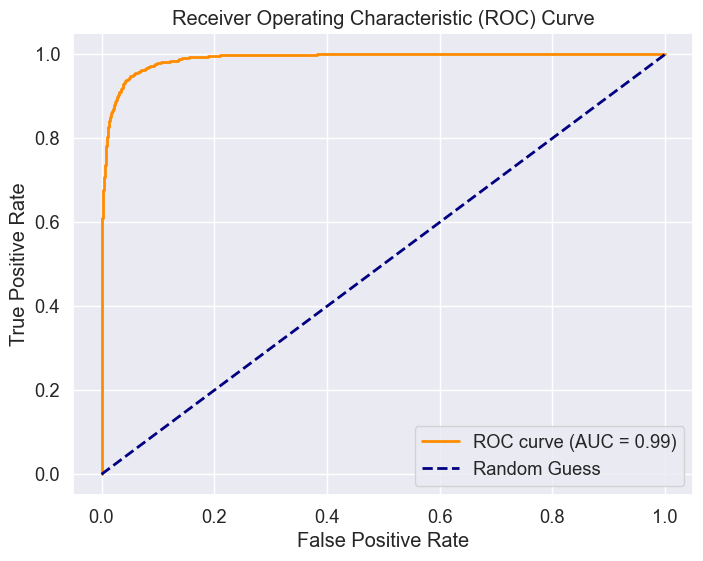

In [249]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
